# - Scenario run: keeping observed shade values in the whole reach and add 25ft veg buffer to each 500km land cover sheet
- Find the top 10 reaches from this scenario and add that land cover to a scenario - report the change in hours or days above july thermal maximum


In [1]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
from scipy.integrate import simps

import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

# Start of Heatsource scenario iterations

## reading in source files (some of these are legacy from old scripts that code relies on, like notoposhade, need to fix)

In [2]:
#reading in data with relative paths so that it can be used by others who clone repository from github
script_dir = os.getcwd()

# the baseline were useing for treeplanting scenatio is all grass and its been extended 5km 
base_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'baseline_vegetation', 'july_baseline_extended_week'))

#Temperature Observations folder
observed_temp_path = os.path.abspath(os.path.join(script_dir, 'observations', 'TemperatureDataObs'))
#Temperature observations
obs = pd.read_csv(os.path.join(observed_temp_path, 'HourlySummer23Master_riverkm.csv'))

#reading in a model run without topographic shading, for use in determining whether a reach is forested or not
notopo_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'notopo_models', 'July_notopo_extended'))

#lc data scenario with buffer, to be used for adding forest to previously foresgrassyted areas
widen20_forestbuffer = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'sensitivity_analysis', 'july_allforestextended_widen20'))
widen30_forestbuffer = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'sensitivity_analysis', 'july_allforestextended_widen30'))
widen40_forestbuffer = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'sensitivity_analysis', 'july_allforestextended_widen40'))



In [3]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
#obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.3, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

In [6]:
notopo_shade_df = pd.read_csv(os.path.join(notopo_source_folder, 'outputs\Shade.csv'), skiprows=6,
         usecols=range(1, 187))
notopo_shade_df.columns = [float(col) for col in notopo_shade_df.columns]
notopo_shade_df = notopo_shade_df.mean()
notopo_shade_df = pd.DataFrame(notopo_shade_df)
notopo_shade_df = notopo_shade_df.reset_index()
#notopo_shade_df.index = obs_clip_mean.index
notopo_shade_df.rename(columns={'index': 'NODE_ID', 0 : 'July Shade'}, inplace=True)


# Heatsource iteration:
- this code reads in the observed baseline model, and iterates through 500m reaches adding shade to the existing landcover data 
- can take a while to run if doing so on monthly models

In [6]:

#Widen 30% scenario#

landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(notopo_source_folder, 'inputs\WFK23_lcdata.csv'))
forestlandcover = pd.read_csv(os.path.join(widen30_forestbuffer, 'inputs\WFK23_lcdata.csv'))
forestmorphology = pd.read_csv(os.path.join(widen30_forestbuffer, 'inputs\WFK23_morphology.csv'))


changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    
    #dont keep simulating once model gets to the extended portion
    if km_start == 5.0:
        break
    
    if isinstance(km_start, float) and km_start % .5 == 0:
        landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        morphology_km = morphology.copy()
        
        
        print(km_start)
        #print('true')
        # if km_start == 18.0:
        #     continue
        km_end = km_start - .5  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = base_source_folder
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'sensitivity_analysis', 'observed_baseline', 'baseline_treeplanting_widen30_7mtree', f'treeplanting_widen30_7mtree_{km_start}'))
        shutil.copytree(original_folder_path, new_folder_path) 


        landcover = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'))
        morphology = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'))
        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = forestlandcover.loc[index, forestlandcover.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            # if reach_shade.loc[index]['July Shade'] > .2:
            #     print('narrowing @: ', index)
                #narrow forested nodes

            # # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
            # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.3
            morphology_km.loc[index, morphology_km.columns[5:6]] = forestmorphology.loc[index, forestmorphology.columns[5:6]]

            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)


        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    


23.5
23.5
23.0
23.0
22.5
22.5
22.0
22.0
21.5
21.5
21.0
21.0
20.5
20.5
20.0
20.0
19.5
19.5
19.0
19.0
18.5
18.5
18.0
18.0
17.5
17.5
17.0
17.0
16.5
16.5
16.0
16.0
15.5
15.5
15.0
15.0
14.5
14.5
14.0
14.0
13.5
13.5
13.0
13.0
12.5
12.5
12.0
12.0
11.5
11.5
11.0
11.0
10.5
10.5
10.0
10.0
9.5
9.5
9.0
9.0
8.5
8.5
8.0
8.0
7.5
7.5
7.0
7.0
6.5
6.5
6.0
6.0
5.5
5.5


In [7]:

#Widen 40% scenario#

landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(notopo_source_folder, 'inputs\WFK23_lcdata.csv'))
forestlandcover = pd.read_csv(os.path.join(widen40_forestbuffer, 'inputs\WFK23_lcdata.csv'))
forestmorphology = pd.read_csv(os.path.join(widen40_forestbuffer, 'inputs\WFK23_morphology.csv'))


changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    
    #dont keep simulating once model gets to the extended portion
    if km_start == 5.0:
        break
    
    if isinstance(km_start, float) and km_start % .5 == 0:
        landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        morphology_km = morphology.copy()
        
        
        print(km_start)
        #print('true')
        # if km_start == 18.0:
        #     continue
        km_end = km_start - .5  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = base_source_folder
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'sensitivity_analysis', 'observed_baseline', 'baseline_treeplanting_widen40_7mtree', f'treeplanting_widen40_7mtree_{km_start}'))
        shutil.copytree(original_folder_path, new_folder_path) 


        landcover = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'))
        morphology = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'))
        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = forestlandcover.loc[index, forestlandcover.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            # if reach_shade.loc[index]['July Shade'] > .2:
            #     print('narrowing @: ', index)
                #narrow forested nodes

            # # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
            # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.3
            morphology_km.loc[index, morphology_km.columns[5:6]] = forestmorphology.loc[index, forestmorphology.columns[5:6]]

            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)


        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    


23.5
23.5
23.0
23.0
22.5
22.5
22.0
22.0
21.5
21.5
21.0
21.0
20.5
20.5
20.0
20.0
19.5
19.5
19.0
19.0
18.5
18.5
18.0
18.0
17.5
17.5
17.0
17.0
16.5
16.5
16.0
16.0
15.5
15.5
15.0
15.0
14.5
14.5
14.0
14.0
13.5
13.5
13.0
13.0
12.5
12.5
12.0
12.0
11.5
11.5
11.0
11.0
10.5
10.5
10.0
10.0
9.5
9.5
9.0
9.0
8.5
8.5
8.0
8.0
7.5
7.5
7.0
7.0
6.5
6.5
6.0
6.0
5.5
5.5


In [4]:
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer

hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled_mean = upstreamconstant_df.resample('D').mean()

upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()

In [8]:

#Widen 20% scenario#

landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(notopo_source_folder, 'inputs\WFK23_lcdata.csv'))
forestlandcover = pd.read_csv(os.path.join(widen20_forestbuffer, 'inputs\WFK23_lcdata.csv'))
forestmorphology = pd.read_csv(os.path.join(widen20_forestbuffer, 'inputs\WFK23_morphology.csv'))


changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    
    #dont keep simulating once model gets to the extended portion
    if km_start == 5.0:
        break
    
    if isinstance(km_start, float) and km_start % .5 == 0:
        landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        morphology_km = morphology.copy()
        
        
        print(km_start)
        #print('true')
        # if km_start == 18.0:
        #     continue
        km_end = km_start - .5  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = base_source_folder
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'sensitivity_analysis', 'observed_baseline', 'baseline_treeplanting_widen20_7mtree2', f'treeplanting_widen20_7mtree_{km_start}'))
        shutil.copytree(original_folder_path, new_folder_path) 


        landcover = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'))
        morphology = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'))
        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = forestlandcover.loc[index, forestlandcover.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            # if reach_shade.loc[index]['July Shade'] > .2:
            #     print('narrowing @: ', index)
                #narrow forested nodes

            # # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
            # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.3
            morphology_km.loc[index, morphology_km.columns[5:6]] = forestmorphology.loc[index, forestmorphology.columns[5:6]]

            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)


        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    


23.5
23.5
23.0
23.0
22.5
22.5
22.0
22.0
21.5
21.5
21.0
21.0
20.5
20.5
20.0
20.0
19.5
19.5
19.0
19.0
18.5
18.5
18.0
18.0
17.5
17.5
17.0
17.0
16.5
16.5
16.0
16.0
15.5
15.5
15.0
15.0
14.5
14.5
14.0
14.0
13.5
13.5
13.0
13.0
12.5
12.5
12.0
12.0
11.5
11.5
11.0
11.0
10.5
10.5
10.0
10.0
9.5
9.5
9.0
9.0
8.5
8.5
8.0
8.0
7.5
7.5
7.0
7.0
6.5
6.5
6.0
6.0
5.5
5.5


## Plotting heatsource results
- plots the results of each 500m reach vs the baseline
- adds attributes about the reach to multiple dictionaries (width, velocity, existing shade, post-scenario shade, change in shade) for use in regression analysis


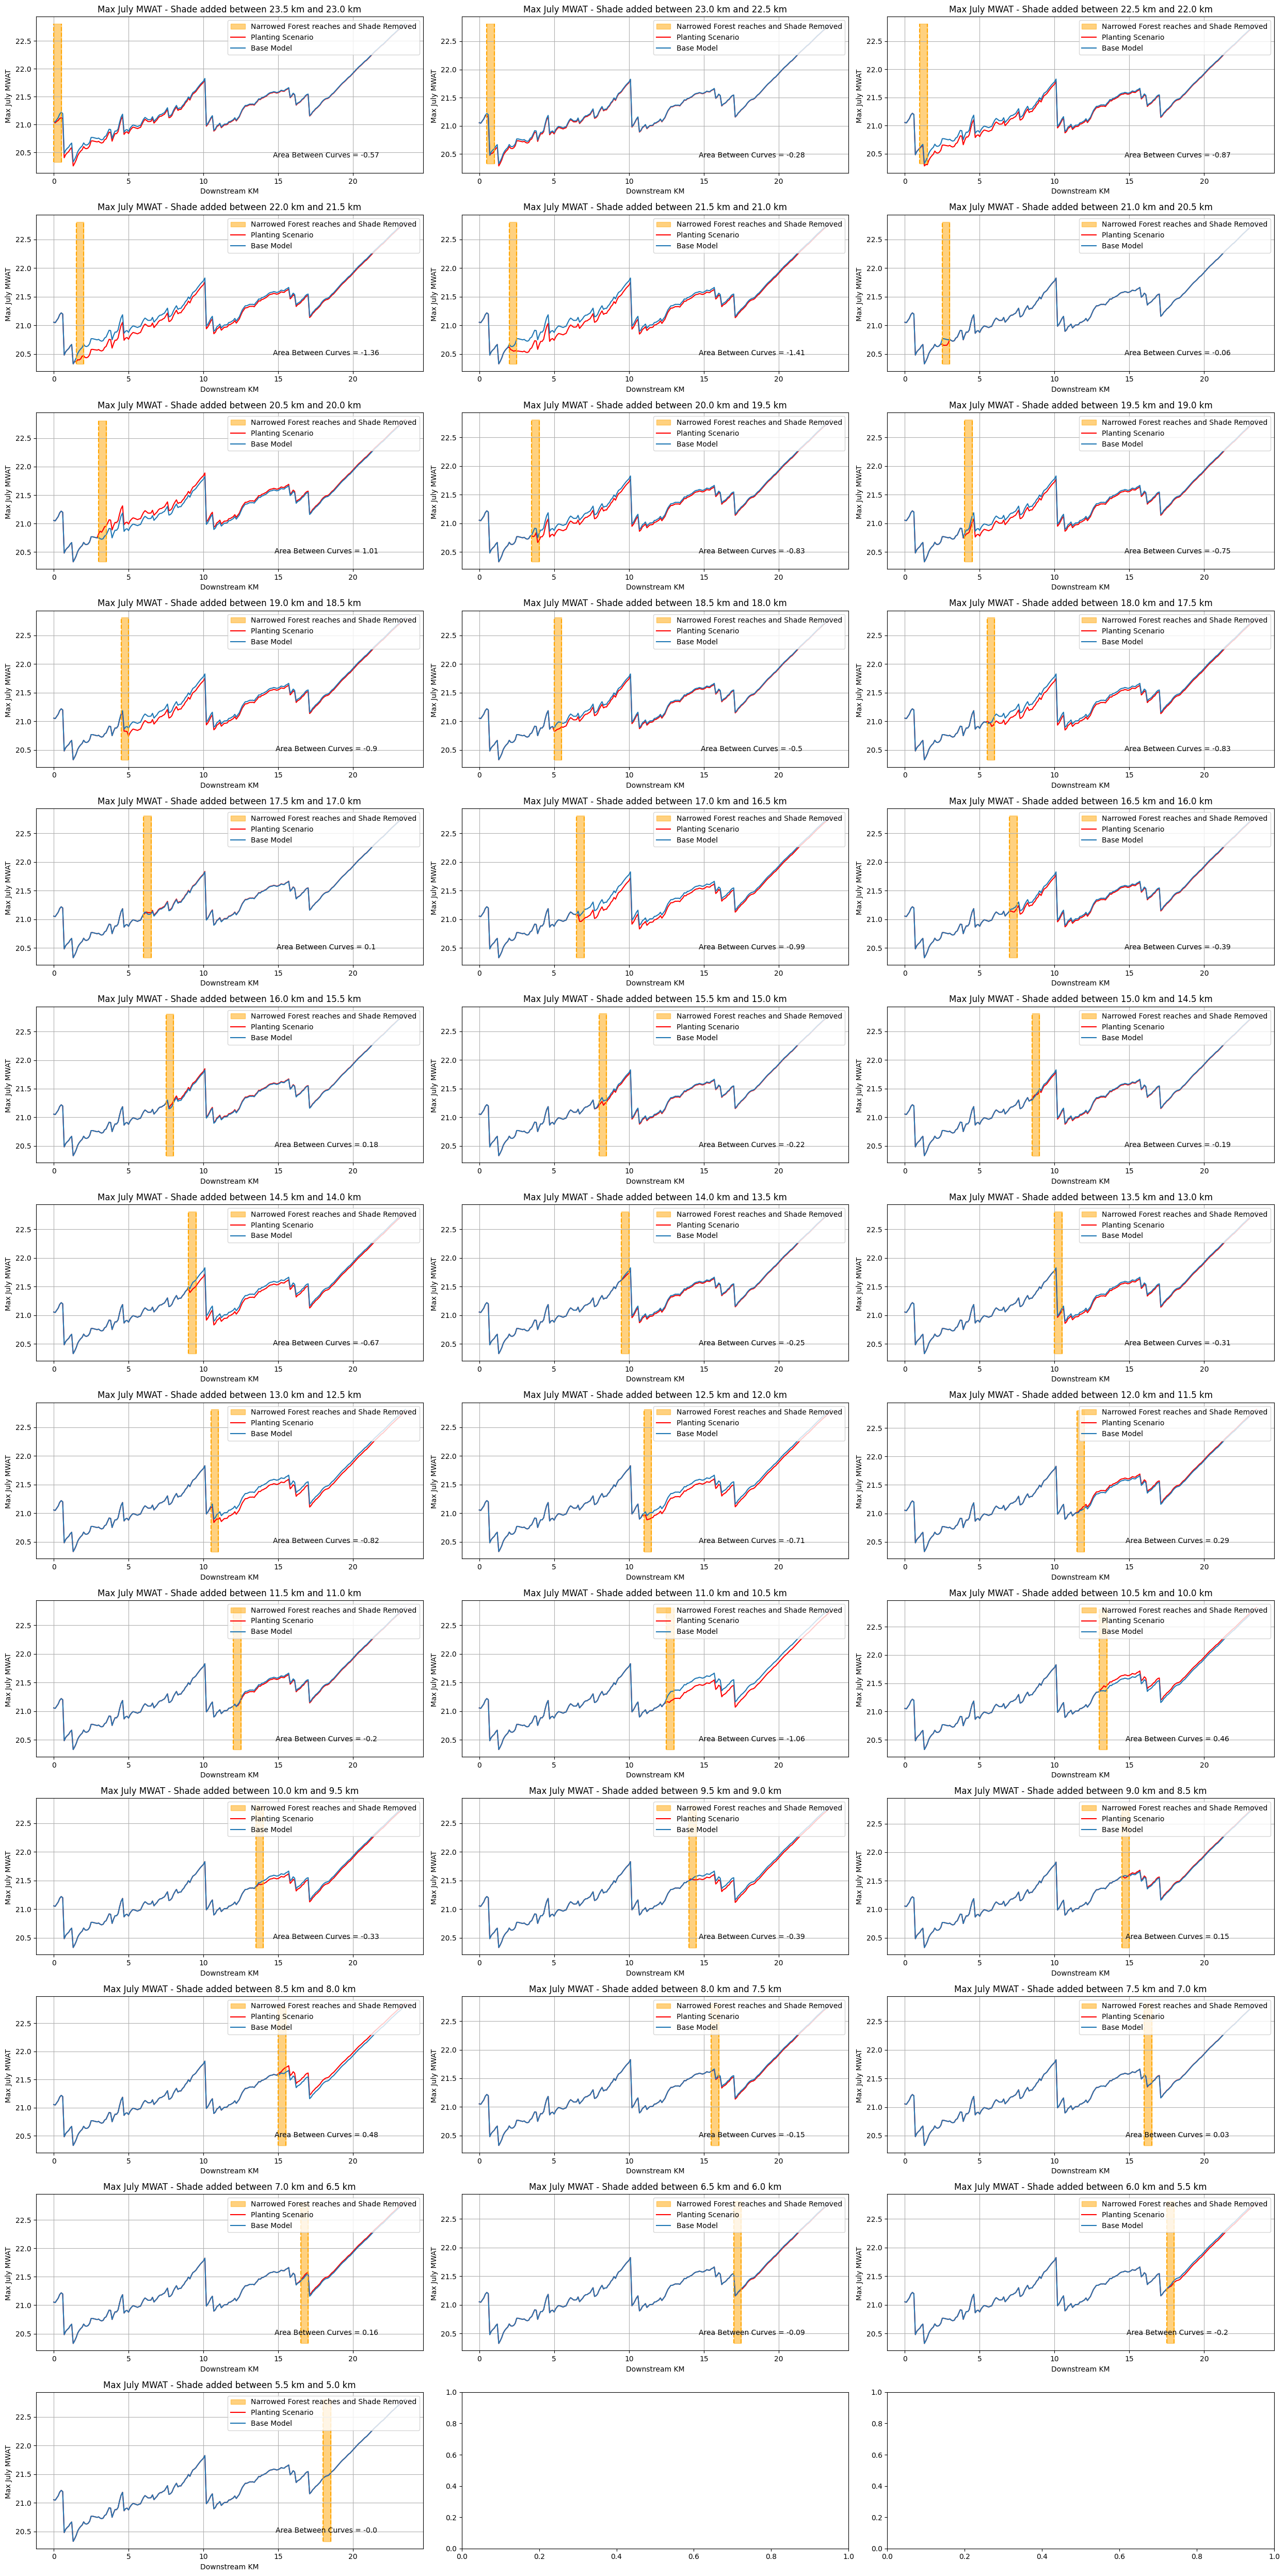

In [62]:
###30% widening Results###
values = [23.5-(x / 2) for x in range(0, 37)]

obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
obs_rolling_avg = upstreamconstant_modeled_mean.rolling(window=7).max()
obs_max_mwat = obs_rolling_avg.max()
upstreamconstant_modeled['Max MWAT'] = obs_max_mwat.values

#base shade scenario
base_shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
base_hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive
base_shade_df.columns = [float(col) for col in base_shade_df.columns]
base_shade_df.index = daily_index
base_shade = base_shade_df.mean()
base_shade = pd.DataFrame(base_shade)
base_shade = base_shade.reset_index()
base_shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)

# base width
base_width = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 237))
base_width.columns = [float(col) for col in base_width.columns]
base_width = base_width.iloc[0]#.to_numpy()
base_width = pd.DataFrame(base_width)
base_width = base_width.reset_index()
base_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)

#dicts to hold differneces between scenarios
effectiveness_difference = {}
reach_shade_base = {}
reach_shade_scenario = {}
reach_shade_change = {}
reach_velocity = {}
reach_width_sim = {}
reach_width_base = {}
reach_width_change = {}

reach_depth = {}
reach_widthdepth = {}
reach_azimuth = {}
reach_gradient = {}
count = 0
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios', 'scenario_outputs', 'sensitivity_analysis', 'observed_baseline', 'baseline_treeplanting_widen30_7mtree', f'treeplanting_widen30_7mtree_{km_start}'))
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        # mean july temperature summary
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        sim__rolling_avg = mean_daily_modeled.rolling(window=7).max()
        sim_max_mwat = sim__rolling_avg.max()
        mean_july_modeled['Max MWAT'] = sim_max_mwat.values
        # mwat = mean_daily_modeled.rolling(window=7).max()
        # mwat = mwat.max()
        # mwat = pd.DataFrame(mwat)
        # mean_july_modeled = pd.merge(mean_july_modeled, mwat[0], left_on='NODE_ID', right_index = True, how='left')
        # mean_july_modeled.rename(columns={0: 'Max MWAT'}, inplace=True) 
        
        #saving reach effectiveness
        # difference = mean_july_modeled['Mean July Temp'] - upstreamconstant_modeled['Mean July Temp']
        # norm_difference = difference/km_start
        # norm_difference = norm_difference.values.sum()
        # norm_effectiveness_difference[km_start] = norm_difference
        # effectiveness_difference[km_start] = difference.values.sum()
        
        #doing integration
        x = mean_july_modeled['NODE_ID']
        y1 = mean_july_modeled['Mean July Temp']
        y2 = upstreamconstant_modeled['Mean July Temp']

        
        
        
        
        # Compute absolute difference between the curves
        abs_diff = np.abs(y1 - y2)

        # Use Simpson's rule for numerical integration
        area = simps(abs_diff, x)
        #changing sign of degree kilomters to be negative or positive based on if its cooling (negative) or warming (positive) from restoration
        if (upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp'] <= 0:
            area = area*-1
        area
        
        effectiveness_difference[km_start] = area
        
        #getting effective shade values
        control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
        cc_start = control_file.loc[7]['VALUE']
        cc_start = pd.to_datetime(cc_start)
        cc_end = control_file.loc[8]['VALUE']
        cc_end = pd.to_datetime(cc_end)
        scenario_shade_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
        # hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive
        #         hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive

        scenario_shade_df.columns = [float(col) for col in scenario_shade_df.columns]
        scenario_shade_df.index = daily_index
        shade = scenario_shade_df.mean()
        shade = pd.DataFrame(shade)
        shade = shade.reset_index()
        shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)
        reach = shade[(shade['NODE_ID'] <= km_start) & (shade['NODE_ID'] >=km_end)]
        base_reach = base_shade[(base_shade['NODE_ID'] <= km_start) & (base_shade['NODE_ID'] >=km_end)]
        #compare base shade to scenario shade
        reach_percent_increase = (base_reach - reach)/base_reach
        reach_difference = reach - base_reach

        reach_mean_percent_increase = reach_percent_increase['Effective Shade %'].mean()    
        #reach_shade[km_start] = reach_mean_percent_increase
        reach_shade_base[km_start] = base_reach['Effective Shade %'].mean()
        reach_shade_scenario[km_start] = reach['Effective Shade %'].mean()
        reach_shade_change[km_start] = reach_difference['Effective Shade %'].mean()

         #get reach azimuth
        azimuth = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        azimuth_reach = azimuth[(azimuth['STREAM_KM'] <= km_start) & (azimuth['STREAM_KM'] >=km_end)]
        azimuth_reach_mean = azimuth_reach['Azm'].mean()
        reach_azimuth[km_start] = abs(azimuth_reach_mean-180)
        
        #get reach gradient 
        gradient = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        gradient_reach = gradient[(gradient['STREAM_KM'] <= km_start) & (gradient['STREAM_KM'] >=km_end)]
        gradient_reach_mean = gradient_reach['GRADIENT'].mean()
        reach_gradient[km_start] = gradient_reach_mean

        #getting mean velocity
        velocity = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Vel.csv'), skiprows=6, usecols=range(1, 237))
        velocity.columns = [float(col) for col in velocity.columns]
        sim_velocity = velocity.mean()#.to_numpy()
        sim_velocity = pd.DataFrame(sim_velocity)
        sim_velocity = sim_velocity.reset_index()
        sim_velocity.rename(columns={'index': 'NODE_ID', 0 : 'Velocity'}, inplace=True)
        velocity_reach = sim_velocity[(sim_velocity['NODE_ID'] <= km_start) & (sim_velocity['NODE_ID'] >=km_end)]
        reach_mean_velocity = velocity_reach['Velocity'].mean()
        reach_velocity[km_start] = reach_mean_velocity
        
        #Getting Width
        sim_width = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 237))
        sim_width.columns = [float(col) for col in sim_width.columns]
        sim_width = sim_width.iloc[0]#.to_numpy()
        sim_width = pd.DataFrame(sim_width)
        sim_width = sim_width.reset_index()
        sim_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)
        sim_width = sim_width[(sim_width['NODE_ID'] <= km_start) & (sim_width['NODE_ID'] >=km_end)]
        reach_width_sim[km_start] = sim_width['Width'].mean()

        base_width_reach = base_width[(base_width['NODE_ID'] <= km_start) & (base_width['NODE_ID'] >=km_end)]
        reach_width_base[km_start] = base_width_reach['Width'].mean()

        reach_width_change[km_start] = reach_width_sim[km_start] - reach_width_base[km_start]
        
        #getting depth
        sim_depth = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_DA.csv'), skiprows=6, usecols=range(1, 237))
        sim_depth.columns = [float(col) for col in sim_depth.columns]
        sim_depth = sim_depth.iloc[0]#.to_numpy()
        sim_depth = pd.DataFrame(sim_depth)
        sim_depth = sim_depth.reset_index()
        sim_depth.rename(columns={'index': 'NODE_ID', 0 : f'Depth'}, inplace=True)
        sim_depth = sim_depth[(sim_depth['NODE_ID'] <= km_start) & (sim_depth['NODE_ID'] >=km_end)]
        reach_depth[km_start] = sim_depth['Depth'].mean()
        #width:depth
        reach_widthdepth[km_start] = (sim_width['Width'].mean()/sim_depth['Depth'].mean())
        #plotting
        # Create a new figure with a 3x3 grid of subplots

        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([23.5 - km_start, 23.5 - km_end], upstreamconstant_modeled['Mean July Temp'].min(),upstreamconstant_modeled['Mean July Temp'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(23.5-mean_july_modeled['NODE_ID'], mean_july_modeled['Mean July Temp'], label=f'Planting Scenario', color = 'red')
        axes[count-1].plot(23.5-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Mean July Temp'], label='Base Model')
        #axes[count-1].set_title(f'Max July MWAT - Shade added between {23.5 - km_start} km and {23.5 - km_end} km')
        axes[count-1].set_title(f'Max July MWAT - Shade added between {km_start} km and {km_end} km')

        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Max July MWAT ')  # Replace 'Y Label' with appropriate label
        axes[count-1].text(0.75, 0.1, f'Area Between Curves = {round(area,2)}', horizontalalignment='center', transform=axes[count-1].transAxes)

        # Plot the shade data on the second y-axis
        # axes[count-1] = axes[count-1].twinx()
        # axes[count-1].plot(23.5-shade.index, shade[0], label='Mean Solar Radiation Flux \n At Stream Surface', color='red', alpha = .5)
        # axes[count-1].set_ylabel('Mean Solar Radiation Flux \n At Stream Surface (W/m2)', color = 'red')
        # axes[count-1].tick_params(axis='y', colors='red')

        axes[count-1].vlines([23.5 - km_start, 23.5 - km_end], ymin = upstreamconstant_modeled['Mean July Temp'].min(), ymax = upstreamconstant_modeled['Mean July Temp'].max(),color = 'orange', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'upper right')

        #axes[count-1].legend(loc = 'lower right')
        # axes[count-1].set_xlim([18.3 - km_end-2, 18.3 - km_start+2 ])


    #plt.show()
    #add vertical line where shade is added              
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
#new_folder_name = f"folder_{km_start}"

In [15]:
for index, row in velocity_reach.iterrows():
    print(row['NODE_ID'])

5.5
5.4
5.3
5.2
5.1
5.0


# Adding scenario results to dataframes
- adds attributes from reach level scenarios ot dataframe
- joins the dataframe to a shapefile of all the reaches

In [64]:
#shapefile with spatial info for 500m restoration reaches
nodes = gpd.read_file(os.path.abspath(os.path.join(script_dir, 'shp', 'centerline_500msplit.shp')))

#making dataframes from info about each restoration reach
reach_shadescenario_dict = pd.DataFrame(list(reach_shade_scenario.items()), columns=['Reach Start KM', 'SR Scenario'])
reach_shadebase_dict = pd.DataFrame(list(reach_shade_base.items()), columns=['Reach Start KM', 'SR Baseline'])
reach_velocity_dict = pd.DataFrame(list(reach_velocity.items()), columns=['Reach Start KM', 'Velocity'])
reach_width_dict = pd.DataFrame(list(reach_width.items()), columns=['Reach Start KM', 'Width'])
reach_depth_dict = pd.DataFrame(list(reach_depth.items()), columns=['Reach Start KM', 'Depth'])
reach_widthdepth_dict = pd.DataFrame(list(reach_widthdepth.items()), columns=['Reach Start KM', 'Width:Depth'])
reach_shadedif_dict = pd.DataFrame(list(reach_shade_change.items()), columns=['Reach Start KM', 'SR Difference'])
reach_azimuth_dict = pd.DataFrame(list(reach_azimuth.items()), columns=['Reach Start KM', 'Mean Azimuth'])
reach_gradient_dict = pd.DataFrame(list(reach_gradient.items()), columns=['Reach Start KM', 'Gradient'])
reach_widthchange_dict = pd.DataFrame(list(reach_width_change.items()), columns=['Reach Start KM', 'Width'])



#creating df to add to 
dif_df_dict = pd.DataFrame(list(effectiveness_difference.items()), columns=['Reach Start KM', 'Degree Kilometers'])

#adding data from scenarios
dif_df_dict['Model Start KM'] = dif_df_dict['Reach Start KM']
dif_df_dict['Reach Start KM'] = dif_df_dict['Reach Start KM']-5
dif_df_dict['Mean velocity'] = reach_velocity_dict['Velocity']
dif_df_dict['Mean Azimuth'] = reach_azimuth_dict['Mean Azimuth']
dif_df_dict['Width'] = reach_width_dict['Width']
dif_df_dict['Depth'] = reach_depth_dict['Depth']
dif_df_dict['Width:Depth'] = reach_widthdepth_dict['Width:Depth']
dif_df_dict['Change in SR'] = reach_shadedif_dict['SR Difference']*100
dif_df_dict['Baseline SR'] = reach_shadebase_dict['SR Baseline'] *100
dif_df_dict['Scenario SR'] = reach_shadescenario_dict['SR Scenario']*100
dif_df_dict['absolute DK'] = abs(dif_df_dict['Degree Kilometers'])
dif_df_dict['Gradient'] = reach_gradient_dict['Gradient']
dif_df_dict['Width Change'] = reach_widthchange_dict['Width']

dif_df_dict['reach2'] = dif_df_dict.index


#dif_df_dict.drop(dif_df_dict.tail(1).index, inplace=True)
dif_df_dict['Distance Downstream'] = 18.5 - dif_df_dict['Reach Start KM']
dif_df_dict = dif_df_dict.sort_values('Degree Kilometers')
dif_df_dict.reset_index(drop=True, inplace=True)
dif_df_dict.index.name = 'Effectiveness Rank'
dif_df_dict.reset_index(inplace=True)
#dif_df_dict.index += 1
merged_gdf_dif = pd.merge(nodes, dif_df_dict[['Reach Start KM','Degree Kilometers', 'Width Change','reach2','absolute DK','Effectiveness Rank', 'Width', 'Baseline SR', 'Change in SR', 'Mean velocity']], left_on='reach2', right_on = 'reach2', how='left')
#merged_gdf_dif.drop(merged_gdf_dif['row'], axis=0, errors='ignore')

#merged_gdf_dif.to_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/extending_model/ranking_treeremoval.shp')
#dif_df_dict.sort_values(by = 'Effectiveness Rank')
#$merged_gdf_dif
merged_gdf_dif

Id  ORIG_FID  ORIG_SEQ  Shape_Leng  reach2  \
0    0         0         4  500.000119      34   
1    0         0         3  499.999985      35   
2    0         0         2  499.999924      36   
3    0         0         5  500.000039      33   
4    0         0         6  500.000046      32   
5    0         0         7  499.999965      31   
6    0         0         8  499.999909      30   
7    0         0         9  500.000054      29   
8    0         0        10  500.000022      28   
9    0         0        12  500.000040      26   
10   0         0        11  499.999955      27   
11   0         0        13  500.000085      25   
12   0         0        14  499.999942      24   
13   0         0        15  500.000046      23   
14   0         0        16  500.000059      22   
15   0         0        17  500.000099      21   
16   0         0        18  499.999973      20   
17   0         0        19  500.000002      19   
18   0         0        20  499.999972      18   
19   0         0        21  500.000145      17   
20   0         0        22  499.999980      16   
21   0         0        23  499.999961      15   
22   0         0        24  499.999867      14   
23   0         0        25  500.000092      13   
24   0         0        26  499.999940      12   
25   0         0        27  500.000045      11   
26   0         0        28  500.000044      10   
27   0         0        29  499.999961       9   
28   0         0        30  500.000020       8   
29   0         0        31  500.000135       7   
30   0         0        32  500.000043       6   
31   0         0        33  499.999999       5   
32   0         0        34  499.999963       4   
33   0         0        35  500.000012       3   
34   0         0        36  499.999982       2   
35   0         0        37  500.000013       1   
36   0         0        38  417.423252       0   

                                             geometry  Reach Start KM  \
0   LINESTRING (539112.629 173034.274, 539112.344 ...             1.5   
1   LINESTRING (539310.692 172939.213, 539310.782 ...             1.0   
2   LINESTRING (539618.146 172853.411, 539619.287 ...             0.5   
3   LINESTRING (538863.403 173202.513, 538862.798 ...             2.0   
4   LINESTRING (538494.291 173497.901, 538491.983 ...             2.5   
5   LINESTRING (538412.909 173913.533, 538411.550 ...             3.0   
6   LINESTRING (538423.841 174268.490, 538423.218 ...             3.5   
7   LINESTRING (538182.590 174549.801, 538180.330 ...             4.0   
8   LINESTRING (538185.259 174961.255, 538187.209 ...             4.5   
9   LINESTRING (537823.444 175371.598, 537816.051 ...             5.5   
10  LINESTRING (538309.440 175341.324, 538307.330 ...             5.0   
11  LINESTRING (537397.236 175591.529, 537391.129 ...             6.0   
12  LINESTRING (537508.404 176023.209, 537508.393 ...             6.5   
13  LINESTRING (537479.451 176373.304, 537477.701 ...             7.0   
14  LINESTRING (537562.016 176742.424, 537562.686 ...             7.5   
15  LINESTRING (537384.261 177020.484, 537380.229 ...             8.0   
16  LINESTRING (537021.408 177288.232, 537017.749 ...             8.5   
17  LINESTRING (536927.701 177627.500, 536931.071 ...             9.0   
18  LINESTRING (537025.544 178005.564, 537028.755 ...             9.5   
19  LINESTRING (537216.635 178444.181, 537218.409 ...            10.0   
20  LINESTRING (537350.298 178870.042, 537350.489 ...            10.5   
21  LINESTRING (537052.290 179207.887, 537050.980 ...            11.0   
22  LINESTRING (536882.821 179639.877, 536883.340 ...            11.5   
23  LINESTRING (536837.752 180068.051, 536844.499 ...            12.0   
24  LINESTRING (537297.553 180206.626, 537300.007 ...            12.5   
25  LINESTRING (537487.282 180530.056, 537486.803 ...            13.0   
26  LINESTRING (537257.950 180965.805, 537257.991 ...            13.5   
27  LINESTRING (537625.004 181257.155, 537627.773 ...      

In [19]:
merged_gdf_dif['Degree Kilometers'].max()

1.0132578611111138

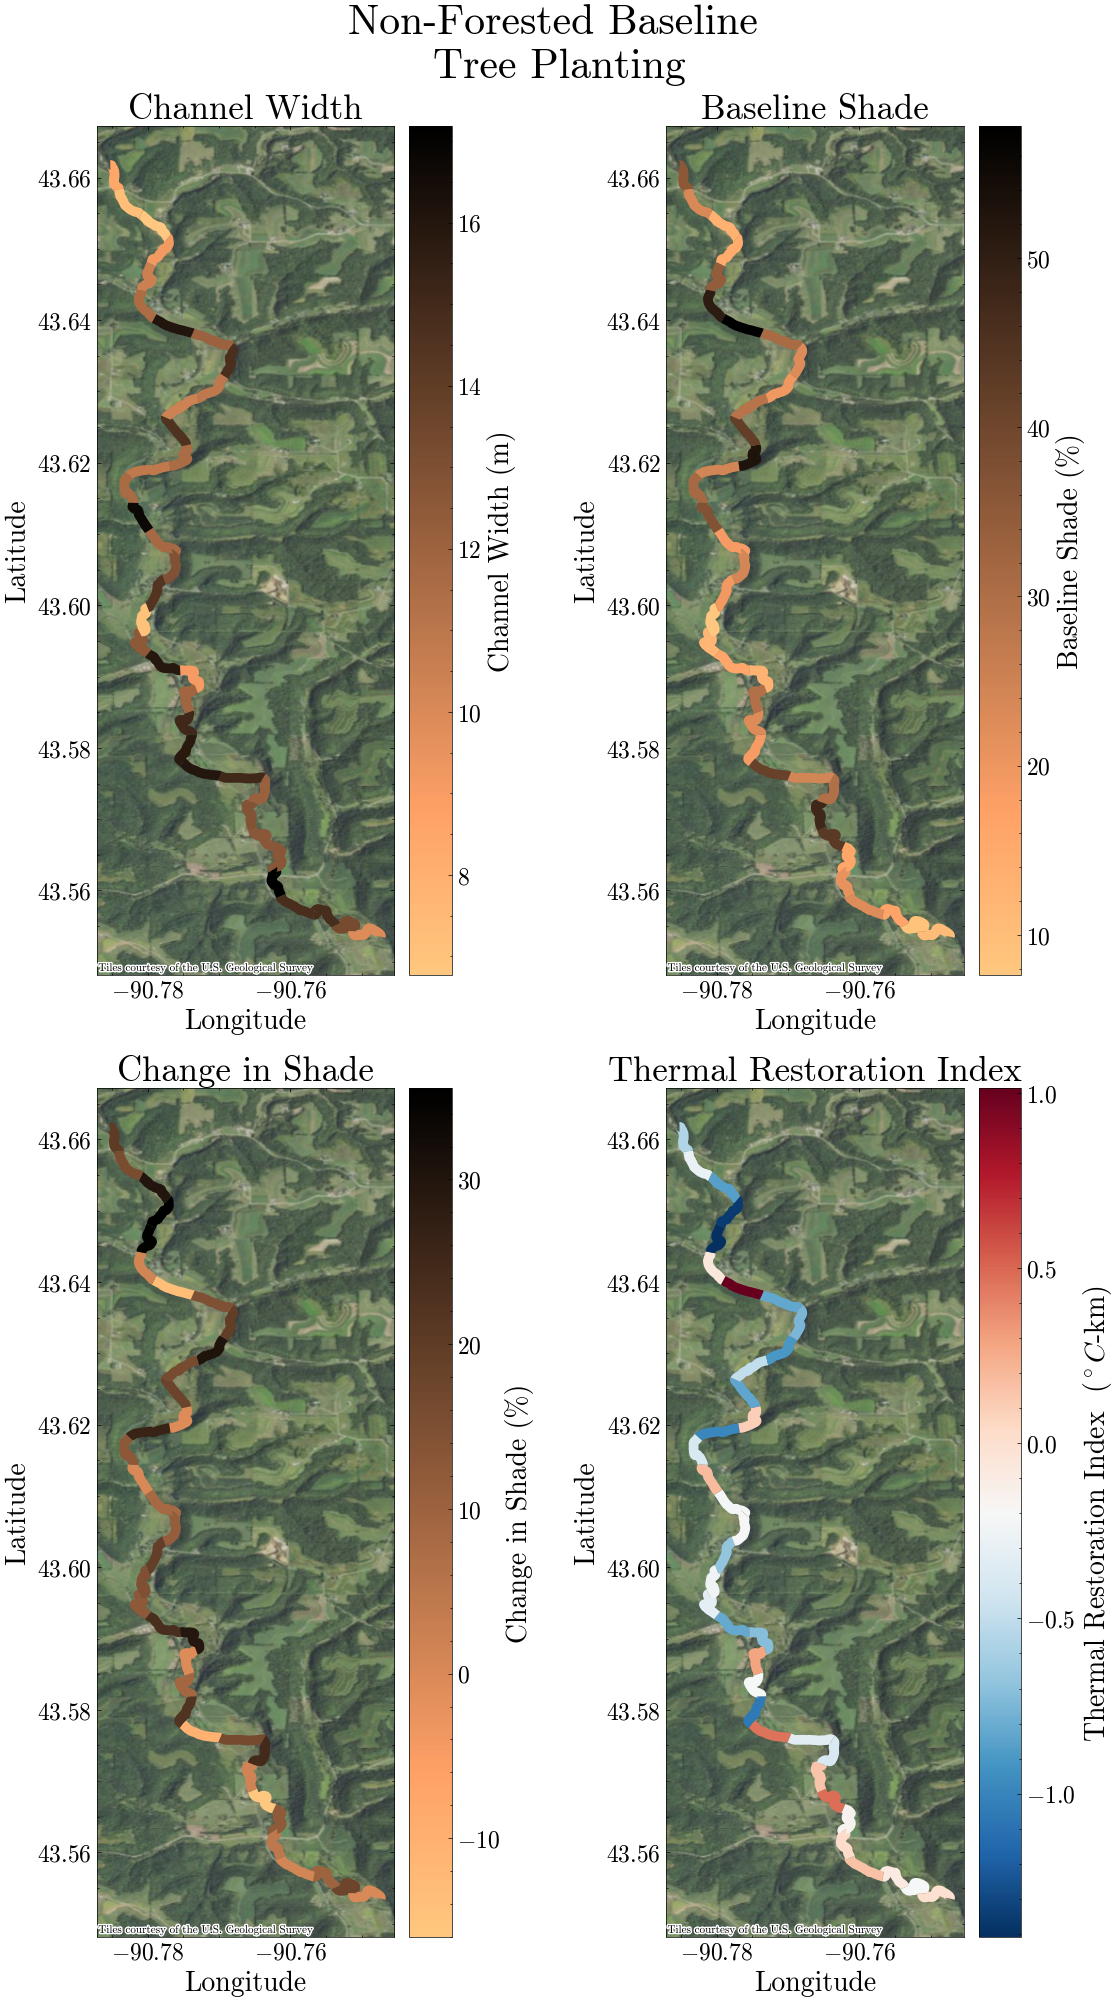

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots


# Define the original colormap
original_cmap = plt.cm.copper
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_width = [merged_gdf_dif['Width'].min(), merged_gdf_dif['Width'].max()]  
bounds_dif = [merged_gdf_dif['Baseline SR'].min(), merged_gdf_dif['Baseline SR'].max()]
bounds_changeSR = [merged_gdf_dif['Change in SR'].min(), merged_gdf_dif['Change in SR'].max()]

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Width'].min(), vmax=merged_gdf_dif['Width'].max())
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Baseline SR'].min(), vmax=merged_gdf_dif['Baseline SR'].max())
norm3 = mcolors.Normalize(vmin=merged_gdf_dif['Change in SR'].min(), vmax=merged_gdf_dif['Change in SR'].max())
norm4 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())

with plt.style.context(['science', 'no-latex']):
    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(2, 2, figsize=(40, 20), layout = 'compressed')
    fig.suptitle('Non-Forested Baseline \nTree Planting', fontsize=30)

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(axes[0], crs=db_lonlat.crs)
    
    # Plot the first map
    ax1 = axes.flat[0]

    #ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm1)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=7, ax=ax1, norm=norm1)

    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 20)
    ax1.set_ylabel('Latitude', fontsize=20)
    ax1.set_title('Channel Width', fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=17)

    # Plot the second map
    ax2 = axes.flat[1]

    # ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=5, ax=axes[1], norm=norm2)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=7, ax=ax2, norm=norm2)

    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Baseline Shade', fontsize=25)
    ax2.set_xlabel('Longitude', fontsize=20)
    ax2.set_ylabel('Latitude', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=17)

    
    ax3 = axes.flat[2]

    # ax3 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=5, ax=axes[2], norm=norm3)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=7, ax=ax3, norm=norm3)

    ctx.add_basemap(ax3, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax3.set_title('Change in Shade', fontsize=25)
    ax3.set_xlabel('Longitude', fontsize=20)
    ax3.set_ylabel('Latitude', fontsize=20)
    ax3.tick_params(axis='both', which='major', labelsize=17)

    ax4 = axes.flat[3]

    # ax4 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=5, ax=axes[3], norm=norm4)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=7, ax=ax4, norm=norm4)

    ctx.add_basemap(ax4, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax4.set_title('Thermal Restoration Index', fontsize=25)
    ax4.set_xlabel('Longitude', fontsize=20)
    ax4.set_ylabel('Latitude', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    # Add colorbars for clarity
    # cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=axes[0], orientation='vertical')
    cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=ax1, orientation='vertical')
    cbar1.set_label('Channel Width (m)', fontsize=20)
    cbar1.ax.tick_params(axis='both', which='major', labelsize=17)


    cbar2 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm2, cmap=inverted_cmap), ax=ax2, orientation='vertical')
    cbar2.set_label('Baseline Shade (%)', fontsize=20)
    cbar2.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar3 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm3, cmap=inverted_cmap), ax=ax3, orientation='vertical')
    cbar3.set_label('Change in Shade (%)', fontsize=20)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar4 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm4, cmap=inverted_degree_cmap), ax=ax4, orientation='vertical')
    cbar4.set_label('Thermal Restoration Index  (${^\circ}C$-km)', fontsize=20)
    cbar4.ax.tick_params(axis='both', which='major', labelsize=17)

    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness.png', bbox_inches='tight', dpi=300)
    plt.savefig(os.path.join(script_dir, 'Figures', 'TreePlantingMapObservedWiden30.png'), bbox_inches='tight', dpi=300)

    plt.show()


# Regression analysis

# Effectiveness maps
- map of effectiveness ranks
- map of degree kilometer change 

# Plotting the top 10 shade reaches implemented vs observed july temps
- i think i need to work on these scenarios - change morphology and landcover in 10 reaches , i think i only did 5


## In a new blank scenario run from july_monthly base,  adding the landcover and morphology attributes from the top 10 most effective reaches

In [210]:
# Finding the top 10 reaches from sorted effeciveness df

km_list = []
for index, row in dif_df_dict.head(10).iterrows():
    km_list.append(row['Model Start KM'])
km_list

[27.0, 26.0, 22.5, 23.5, 20.5, 26.5, 18.0, 13.0, 25.0, 19.5]

In [137]:
#folder of top 10 scenario i want to fill with reach by reach scenario data
for i in km_list:
    top10_source = f'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\ModelBaselines\\top10_restorationscenario'
    landcover_top10 = pd.read_csv(os.path.join(top10_source, 'inputs\WFK23_lcdata.csv'))
    morhpology_top10 = pd.read_csv(os.path.join(top10_source, 'inputs\WFK23_morphology.csv'))
    # loop to getlandcover files for the top 10 
    km_start = i
    km_end = km_start - .5
    #reach files
    reach_source_folder =  f'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\observedbaseline_shading2\\reach_{km_start}'
    landcover_reach = pd.read_csv(os.path.join(reach_source_folder, 'inputs\WFK23_lcdata.csv'))
    morphology_reach = pd.read_csv(os.path.join(reach_source_folder, 'inputs\WFK23_morphology.csv'))
    reach = landcover[(landcover['STREAM_KM'] <= km_start) & (landcover['STREAM_KM']>km_end)]
    print(reach)
    #loop through each row in reach and change landcover and morphology to forest
    for index, row in reach.iterrows():
        #write landcover from shade scenario to top10 scenario
        landcover_top10.loc[index, landcover_km.columns[8:48]] = landcover_reach.loc[index, landcover_reach.columns[8:48]]
        landcover_top10.to_csv(os.path.join(top10_source, 'inputs\WFK23_lcdata.csv'), index = False)

        # write morphology from shade landcover scenario to top10 scenario
        morhpology_top10.loc[index,morhpology_top10.columns[5]] = morphology_reach.loc[index,morphology_reach.columns[5]]
        morhpology_top10.to_csv(os.path.join(top10_source, 'inputs\WFK23_morphology.csv'), index = False)


   STREAM_ID  NODE_ID  STREAM_KM  LONGITUDE   LATITUDE     TOPO_W     TOPO_S  \
2        NaN      270       27.0 -90.784700  43.659290  11.179962   9.486133   
3        NaN      269       26.9 -90.784059  43.658572   5.904243   9.684961   
4        NaN      268       26.8 -90.783903  43.657690   3.955325  12.820139   
5        NaN      267       26.7 -90.783509  43.656848  13.284937  15.656237   
6        NaN      266       26.6 -90.783038  43.656025  28.381892  25.256129   

      TOPO_E  LC_T0_S0  LC_T1_S1  ...  ELE_T7_S1  ELE_T7_S2  ELE_T7_S3  \
2  12.773587         0         0  ...  291.50427  291.50427  292.36673   
3  10.507494         0         0  ...  288.15982  288.44537  288.37160   
4   7.181208         0         0  ...  287.15253  287.15253  287.22840   
5   3.436115         0         0  ...  286.50842  286.53244  286.53244   
6   4.377926         0         0  ...  286.45004  286.39337  286.39337   

   ELE_T7_S4  ELE_T7_S5  ELE_T8_S1  ELE_T8_S2  ELE_T8_S3  ELE_T8_S4  ELE_T

In [109]:
def mwmt(source_folder):
    model_tw_df = pd.read_csv(os.path.join(source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
    control_file = pd.read_csv(os.path.join(source_folder, 'HeatSource_Control.csv'))
    #fill in dates/times for index of model output
    cc_start = control_file.loc[7]['VALUE']
    cc_start = pd.to_datetime(cc_start)
    cc_end = control_file.loc[8]['VALUE']
    cc_end = pd.to_datetime(cc_end)
    hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive
    model_tw_df.columns = [float(col) for col in model_tw_df.columns]
    model_tw_df.index = hourly_index
    #mean & max july
    mean_daily_shade = allshade_tw_df.resample('D').mean()
    #adding MWMT
    mwmt = max_daily_shade.rolling(window=7).max()
    mwmt = shaded_mwmt.max()
    mwmt = pd.DataFrame(shaded_mwmt)
    return mwmt


## Calculating temp metrics for base and scenario models 

In [252]:
top10_scenario = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\top10_restorationscenario'
allshade_tw_df = pd.read_csv(os.path.join(top10_scenario, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 185))
allshade_tw_df.columns = [float(col) for col in allshade_tw_df.columns]
obs_clip_day = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]

allshade_tw_df.index = pd.to_datetime(obs_clip_day.index)
#mean & max july
mean_daily_shade = allshade_tw_df.mean()
max_daily_shade = allshade_tw_df.max()

#adding MWAT

mean_daily_shade = allshade_tw_df.resample('D').mean()
shaded_mwat = mean_daily_shade.rolling(window=7).mean()
shaded_mwat = shaded_mwat.max()
shaded_mwat = pd.DataFrame(mean_daily_shade)

#adding MWMT
# shaded_mwmt = max_daily_shade.rolling(window=7).max()
# shaded_mwmt = shaded_mwmt.max()
shaded_mwmt = pd.DataFrame(max_daily_shade)
shaded_mean =  pd.DataFrame(mean_daily_shade)
shaded_max =  pd.DataFrame(max_daily_shade)

allshade_tw_df

27.2     27.1     27.0     26.9     26.8  \
1970-01-01 00:00:00.000001525  20.817  20.8127  20.8120  20.8094  20.8095   
1970-01-01 00:00:00.000001526  20.484  20.4962  20.5033  20.4919  20.4888   
1970-01-01 00:00:00.000001527  20.150  20.1685  20.1819  20.1783  20.1817   
1970-01-01 00:00:00.000001528  19.841  19.8584  19.8720  19.8691  19.8741   
1970-01-01 00:00:00.000001529  19.484  19.5134  19.5369  19.5448  19.5581   
...                               ...      ...      ...      ...      ...   
1970-01-01 00:00:00.000002264  24.171  24.1475  24.0969  24.0400  23.9939   
1970-01-01 00:00:00.000002265  23.232  23.2826  23.2954  23.2982  23.3017   
1970-01-01 00:00:00.000002266  22.202  22.2714  22.3070  22.3270  22.3523   
1970-01-01 00:00:00.000002267  21.246  21.3256  21.3737  21.4080  21.4448   
1970-01-01 00:00:00.000002268  20.460  20.5259  20.5678  20.5973  20.6319   

                                  26.7     26.6     26.5     26.4     26.3  \
1970-01-01 00:00:00.000001525  20.8148  20.7462  20.8116  20.8129  20.8120   
1970-01-01 00:00:00.000001526  20.5149  19.9353  19.9971  20.0458  20.1017   
1970-01-01 00:00:00.000001527  20.2132  19.6463  19.6926  19.7185  19.7392   
1970-01-01 00:00:00.000001528  19.9073  19.3532  19.4022  19.4301  19.4517   
1970-01-01 00:00:00.000001529  19.5993  19.0585  19.1116  19.1424  19.1666   
...                                ...      ...      ...      ...      ...   
1970-01-01 00:00:00.000002264  23.9988  23.1666  23.1697  23.1409  23.1037   
1970-01-01 00:00:00.000002265  23.3686  22.6000  22.6612  22.6733  22.6725   
1970-01-01 00:00:00.000002266  22.4569  21.7725  21.8863  21.9370  21.9715   
1970-01-01 00:00:00.000002267  21.5512  20.9288  21.0485  21.1129  21.1658   
1970-01-01 00:00:00.000002268  20.7302  20.1549  20.2710  20.3378  20.3950   

                               ...     9.8      9.7      9.6      9.5   \
1970-01-01 00:00:00.000001525  ...  20.8120  20.8137  20.8128  20.8112   
1970-01-01 00:00:00.000001526  ...  20.3161  20.3488  20.3768  20.3936   
1970-01-01 00:00:00.000001527  ...  19.9816  19.9995  20.0123  20.0197   
1970-01-01 00:00:00.000001528  ...  19.7454  19.7561  19.7621  19.7652   
1970-01-01 00:00:00.000001529  ...  19.5787  19.5842  19.5850  19.5844   
...                            ...      ...      ...      ...      ...   
1970-01-01 00:00:00.000002264  ...  21.9839  22.0150  22.0369  22.0560   
1970-01-01 00:00:00.000002265  ...  21.5900  21.6086  21.6211  21.6293   
1970-01-01 00:00:00.000002266  ...  21.2510  21.2557  21.2545  21.2507   
1970-01-01 00:00:00.000002267  ...  21.0406  21.0346  21.0226  21.0114   
1970-01-01 00:00:00.000002268  ...  20.9091  20.8972  20.8790  20.8623   

                                  9.4      9.3      9.2      9.1      9.0   \
1970-01-01 00:00:00.000001525  20.8117  20.8105  20.8124  20.8090  20.8105   
1970-01-01 00:00:00.000001526  20.4126  20.4266  20.4454  20.4515  20.4649   
1970-01-01 00:00:00.000001527  20.0293  20.0349  20.0460  20.0469  20.0563   
1970-01-01 00:00:00.000001528  19.7705  19.7721  19.7791  19.7767  19.7822   
1970-01-01 00:00:00.000001529  19.5860  19.5839  19.5871  19.5813  19.5832   
...                                ...      ...      ...      ...      ...   
1970-01-01 00:00:00.000002264  22.0813  22.0957  22.1152  22.1231  22.1429   
1970-01-01 00:00:00.000002265  21.6410  21.6475  21.6598  21.6603  21.6716   
1970-01-01 00:00:00.000002266  21.2509  21.2481  21.2526  21.2455  21.2482   
1970-01-01 00:00:00.000002267  21.0039  20.9933  20.9901  20.9760  20.9711   
1970-01-01 00:00:00.000002268  20.8492  20.8335  20.8250  20.8059  20.7954   

                                  8.9   
1970-01-01 00:00:00.000001525  20.8123  
1970-01-01 00:00:00.000001526  20.4833  
1970-01-01 00:00:00.000001527  20.0705  
1970-01-01 00:00:00.000001528  19.7914  
1970-01-01 00:00:00.000001529  19.5879  
...                                ...  
1970-01-01 00:00:00.000002264  22.1684  
1970-01-01 00:00:

In [226]:
monthly_observed_source_folder = r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\july_monthly_extended'

upstreamconstant_df = pd.read_csv(os.path.join(monthly_observed_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 185))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip_day.index
# mean july temperature summary
upstreamconstant_modeled_mean = upstreamconstant_df.mean()
upstreamconstant_modeled_max = upstreamconstant_df.max()
upstreamconstant_modeled_max = pd.DataFrame(upstreamconstant_modeled_max)
upstreamconstant_modeled_mean = pd.DataFrame(upstreamconstant_modeled_mean)
upstreamconstant_modeled_mean

0
27.2  20.065344
27.1  20.100311
27.0  20.143239
26.9  20.235305
26.8  20.308658
...         ...
9.3   21.121668
9.2   21.139335
9.1   21.148291
9.0   21.170661
8.9   21.197140

[184 rows x 1 columns]

In [232]:
base_mwmt_df = pd.DataFrame(base_mwmt.max())
scenario_mwmt_df = pd.DataFrame(scenario_mwmt.max())
base_mwat_df = pd.DataFrame(base_mwat.max())
scenario_mwat_df = pd.DataFrame(scenario_mwat.max())

### Plotting scenario next to 2023 July baseline

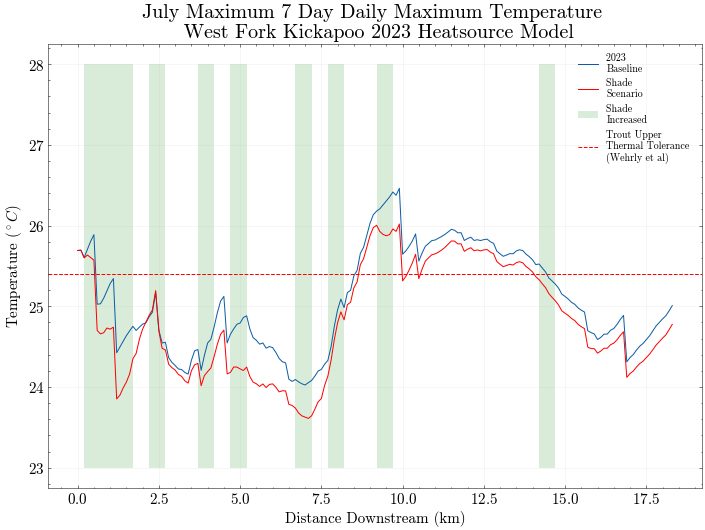

In [238]:
## July Mean

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(27.2 - base_mwmt_df.index, base_mwmt_df[0], label='2023 \nBaseline')
    plt.plot(27.2 - scenario_mwmt_df.index, scenario_mwmt_df[0], label='Shade \nScenario', color = 'red')
    for i in km_list:
        if i == 27.0:
            plt.fill_between([27.2 - i, 27.2 - (i-.5)], 23,28, color='green', edgecolor = None, alpha = .15, label = 'Shade \nIncreased')
        else:
            plt.fill_between([27.2 - i, 27.2 - (i-.5)], 23,28, color='green', edgecolor = None, alpha = .15)

    # dumb way to add a single label for shade additions
    # plt.fill_between([27.2 - 27.0, 27.2 - (27.0 -.5)], shaded_mean[0].min(),upstreamconstant_modeled_mean[0].max(), color='green', alpha = .15, label = 'Additional \nShading')

    x = np.linspace(-1,18.8,10)
    # plt.fill_between(x,25, 23.5, color = 'red', alpha = .2, label='Trout Upper Thermal Tolerance \n(Wehrly et al)')
    plt.ylabel('Temperature (${^\circ}C$)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')
    plt.axhline(y=25.4, linestyle='--', color='red', label='Trout Upper \nThermal Tolerance \n(Wehrly et al)')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    #plt.ylim(19, 21.5)
    # plt.xlim(-.5, 18.8)

    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 10)
    plt.title('July Maximum 7 Day Daily Maximum Temperature \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Top10JulyMaxTemp.png',bbox_inches='tight', dpi=300)
    plt.show()
    

In [241]:
scenario_mwmt_df

0
27.2  25.691571
27.1  25.695486
27.0  25.599857
26.9  25.635243
26.8  25.604471
...         ...
9.3   24.561243
9.2   24.605157
9.1   24.644657
9.0   24.708729
8.9   24.775743

[184 rows x 1 columns]

In [246]:
#TRI of 10 day change
x = 27.2- scenario_mwmt_df.index
y1 = scenario_mwmt_df[0]
y2 = base_mwmt_df[0]





# Compute absolute difference between the curves
abs_diff = np.abs(y1 - y2)
diff = y1 - y2

# Use Simpson's rule for numerical integration
area = simps(diff, x)
area

-4.565776666666666

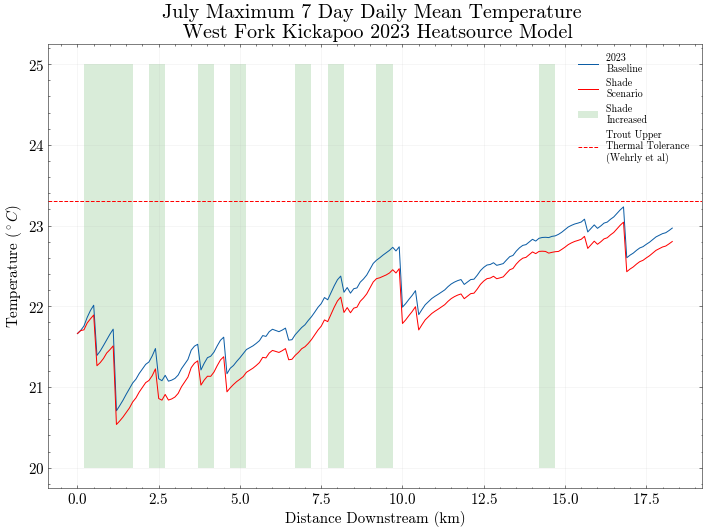

In [239]:
## July Mean

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(27.2 - base_mwat_df.index, base_mwat_df[0], label='2023 \nBaseline')
    plt.plot(27.2 - scenario_mwat_df.index, scenario_mwat_df[0], label='Shade \nScenario', color = 'red')
    for i in km_list:
        if i == 27.0:
            plt.fill_between([27.2 - i, 27.2 - (i-.5)], 20,25, color='green', edgecolor = None, alpha = .15, label = 'Shade \nIncreased')
        else:
            plt.fill_between([27.2 - i, 27.2 - (i-.5)], 20,25, color='green', edgecolor = None, alpha = .15)

    # dumb way to add a single label for shade additions
    # plt.fill_between([27.2 - 27.0, 27.2 - (27.0 -.5)], shaded_mean[0].min(),upstreamconstant_modeled_mean[0].max(), color='green', alpha = .15, label = 'Additional \nShading')

    x = np.linspace(-1,18.8,10)
    # plt.fill_between(x,25, 23.5, color = 'red', alpha = .2, label='Trout Upper Thermal Tolerance \n(Wehrly et al)')
    plt.ylabel('Temperature (${^\circ}C$)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')
    plt.axhline(y=23.3, linestyle='--', color='red', label='Trout Upper \nThermal Tolerance \n(Wehrly et al)')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    #plt.ylim(19, 21.5)
    # plt.xlim(-.5, 18.8)

    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 10)
    plt.title('July Maximum 7 Day Daily Mean Temperature \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Top10JulyMeanTemp.png',bbox_inches='tight', dpi=300)
    plt.show()

###  Difference between max and min temp differences, scenario vs baseline

In [40]:
max_diff_df = upstreamconstant_modeled_max - shaded_max
max_index = max_diff_df.idxmax()
max_value = max_diff_df.loc[max_index]

print("Index where the maximum value occurs:", max_index)
print("Value at that index:", max_value)
max_index-27.2

Index where the maximum value occurs: 0    26.1
dtype: float64
Value at that index:            0
26.1  0.7089


0   -1.1
dtype: float64

In [41]:
## Where did means cool the most
mean_diff_df = upstreamconstant_modeled_mean - shaded_mean
max_index = mean_diff_df.idxmax()
max_value = mean_diff_df.loc[max_index]

# print("Index where the maximum value occurs:", max_index)
# print("Value at that index:", max_value)
# max_index-27.2
model_value = upstreamconstant_modeled_mean.loc[max_index]
scenario_value = shaded_mean.loc[max_index]

scenario_value

0
20.1  19.992953

In [57]:
#how much did the highest mean cool
max_mean_idx = upstreamconstant_modeled_mean.idxmax()
max_mean = upstreamconstant_modeled_mean.loc[max_mean_idx]
max_mean_cooled = shaded_mean.loc[max_mean_idx]
max_mean_cooled_dif = max_mean_cooled - max_mean
max_mean_idx


0    10.4
dtype: float64

In [43]:
max_max_idx = upstreamconstant_modeled_max.idxmax()
max_max= upstreamconstant_modeled_max.loc[max_max_idx]
max_max_cooled = shaded_max.loc[max_max_idx]
max_max_cooled_dif = max_max - max_max_cooled
max_max_cooled_dif


0
17.3  0.4933

## Finding days above MWAT and MWMT Temp Thresholds

In [46]:
#MWaT BASELINE
obs_clip_day = obs_clip_day.set_index('datetime')

upstreamconstant_df.index = obs_clip_day.index
mean_daily_base = upstreamconstant_df.resample('D').mean()
# base_mwat = mean_daily_base.rolling(window=7).max()
base_mwat = mean_daily_base.rolling(window=7).mean()

basemwat_above_threshold = base_mwat.apply(lambda col: (col > 23.3).sum())
basemwat_above_threshold = pd.DataFrame(basemwat_above_threshold)
basemwat_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 23.3'}, inplace=True)

#MWMT BASELINE

#upstreamconstant_df.index = obs_clip_day.index
max_daily_base = upstreamconstant_df.resample('D').max()
base_mwmt = max_daily_base.rolling(window=7).mean()
basemwmt_above_threshold = base_mwmt.apply(lambda col: (col > 25.4).sum())
basemwmt_above_threshold = pd.DataFrame(basemwmt_above_threshold)
basemwmt_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 25.4'}, inplace=True)

basemwmt_above_threshold



Days > 25.4
27.2            4
27.1            4
27.0            4
26.9            4
26.8            4
...           ...
9.3             0
9.2             0
9.1             0
9.0             0
8.9             0

[184 rows x 1 columns]

In [58]:
#MWAT Scenario

allshade_tw_df.index = obs_clip_day.index
#mean & max july
mean_daily_shade = allshade_tw_df.resample('D').mean()
scenario_mwat = mean_daily_shade.rolling(window=7).mean()
scenario_mwat
#scenario_mwat.rename(columns={'index': 'NODE_ID', 0 : 'MWAT'}, inplace=True)
scenariomwat_above_threshold = scenario_mwat.apply(lambda col: (col > 23.3).sum())
scenariomwat_above_threshold = pd.DataFrame(scenariomwat_above_threshold)
scenariomwat_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 23.3'}, inplace=True)

# #MWMT scenaroi

max_daily_shade = allshade_tw_df.resample('D').max()
scenario_mwmt = max_daily_shade.rolling(window=7).mean()
scenariomwmt_above_threshold = scenario_mwmt.apply(lambda col: (col > 25.4).sum())
scenariomwmt_above_threshold = pd.DataFrame(scenariomwmt_above_threshold)
scenariomwmt_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 25.4'}, inplace=True)

scenariomwmt_above_threshold

Days > 25.4
27.2            4
27.1            4
27.0            4
26.9            4
26.8            3
...           ...
9.3             0
9.2             0
9.1             0
9.0             0
8.9             0

[184 rows x 1 columns]

## Plotting Days above Threshold Base and Scenario

In [76]:
#Difference in days above threshold MWMT 
MWMT_difference =  abs(scenariomwmt_above_threshold - basemwmt_above_threshold)
MWMT_daydifference = MWMT_difference[MWMT_difference['Days > 25.4']>2]
MWMT_daydifference.index = 27.2 - MWMT_daydifference.index
# len(MWMT_daydifference['Days > 25.4'])
MWMT_daydifference

Days > 25.4
10.0            3
10.1            3

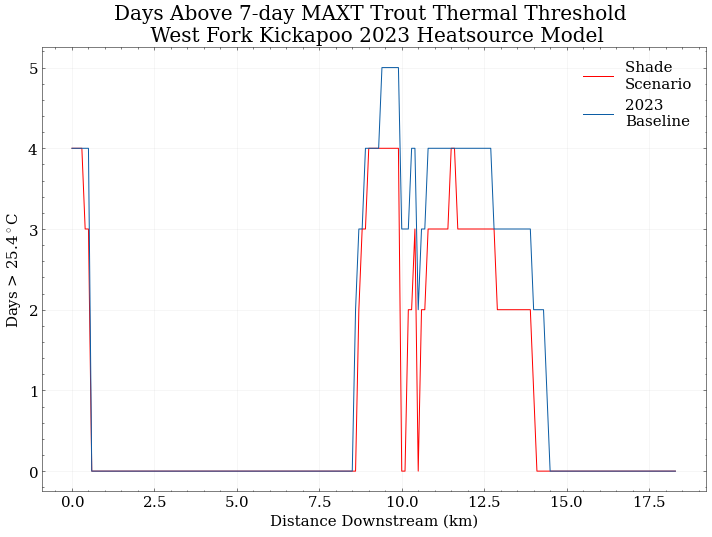

In [254]:
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(27.2-scenariomwmt_above_threshold.index, scenariomwmt_above_threshold['Days > 25.4'], label=f'Shade \nScenario', color = 'red')
    plt.plot(27.2-basemwmt_above_threshold.index, basemwmt_above_threshold['Days > 25.4'], label='2023 \nBaseline')
    plt.ylabel('Days > 25.4${^\circ}$C', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title('Days Above 7-day MAXT Trout Thermal Threshold \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.grid(alpha = .2)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\DaysAboveMWMTThreshold.png',bbox_inches='tight', dpi=300)

# axes[count-1].set_title(f'Hours above 22.3 - Shade added between {km_start} km and {km_end} km')
# axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
# axes[count-1].set_ylabel('Hours')  # Replace 'Y Label' with appropriate label


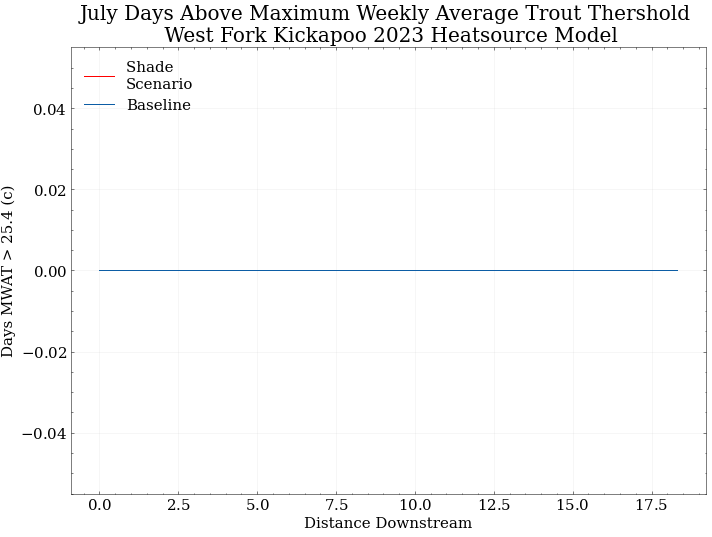

In [284]:
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(27.2-scenariomwat_above_threshold.index, scenariomwat_above_threshold['Days > 23.3'], label=f'Shade \nScenario', color = 'red')
    plt.plot(27.2-basemwat_above_threshold.index, basemwat_above_threshold['Days > 23.3'], label='Baseline')
    plt.ylabel('Days MWAT > 25.4 (c)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.title('July Days Above Maximum Weekly Average Trout Thershold \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.grid(alpha = .2)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\ModelOutputs\DaysAboveMWATThreshold.png',bbox_inches='tight', dpi=300)

# axes[count-1].set_title(f'Hours above 22.3 - Shade added between {km_start} km and {km_end} km')
# axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
# axes[count-1].set_ylabel('Hours')  # Replace 'Y Label' with appropriate label


## Testing getting plottable metrics for each node instead of a 500m reach

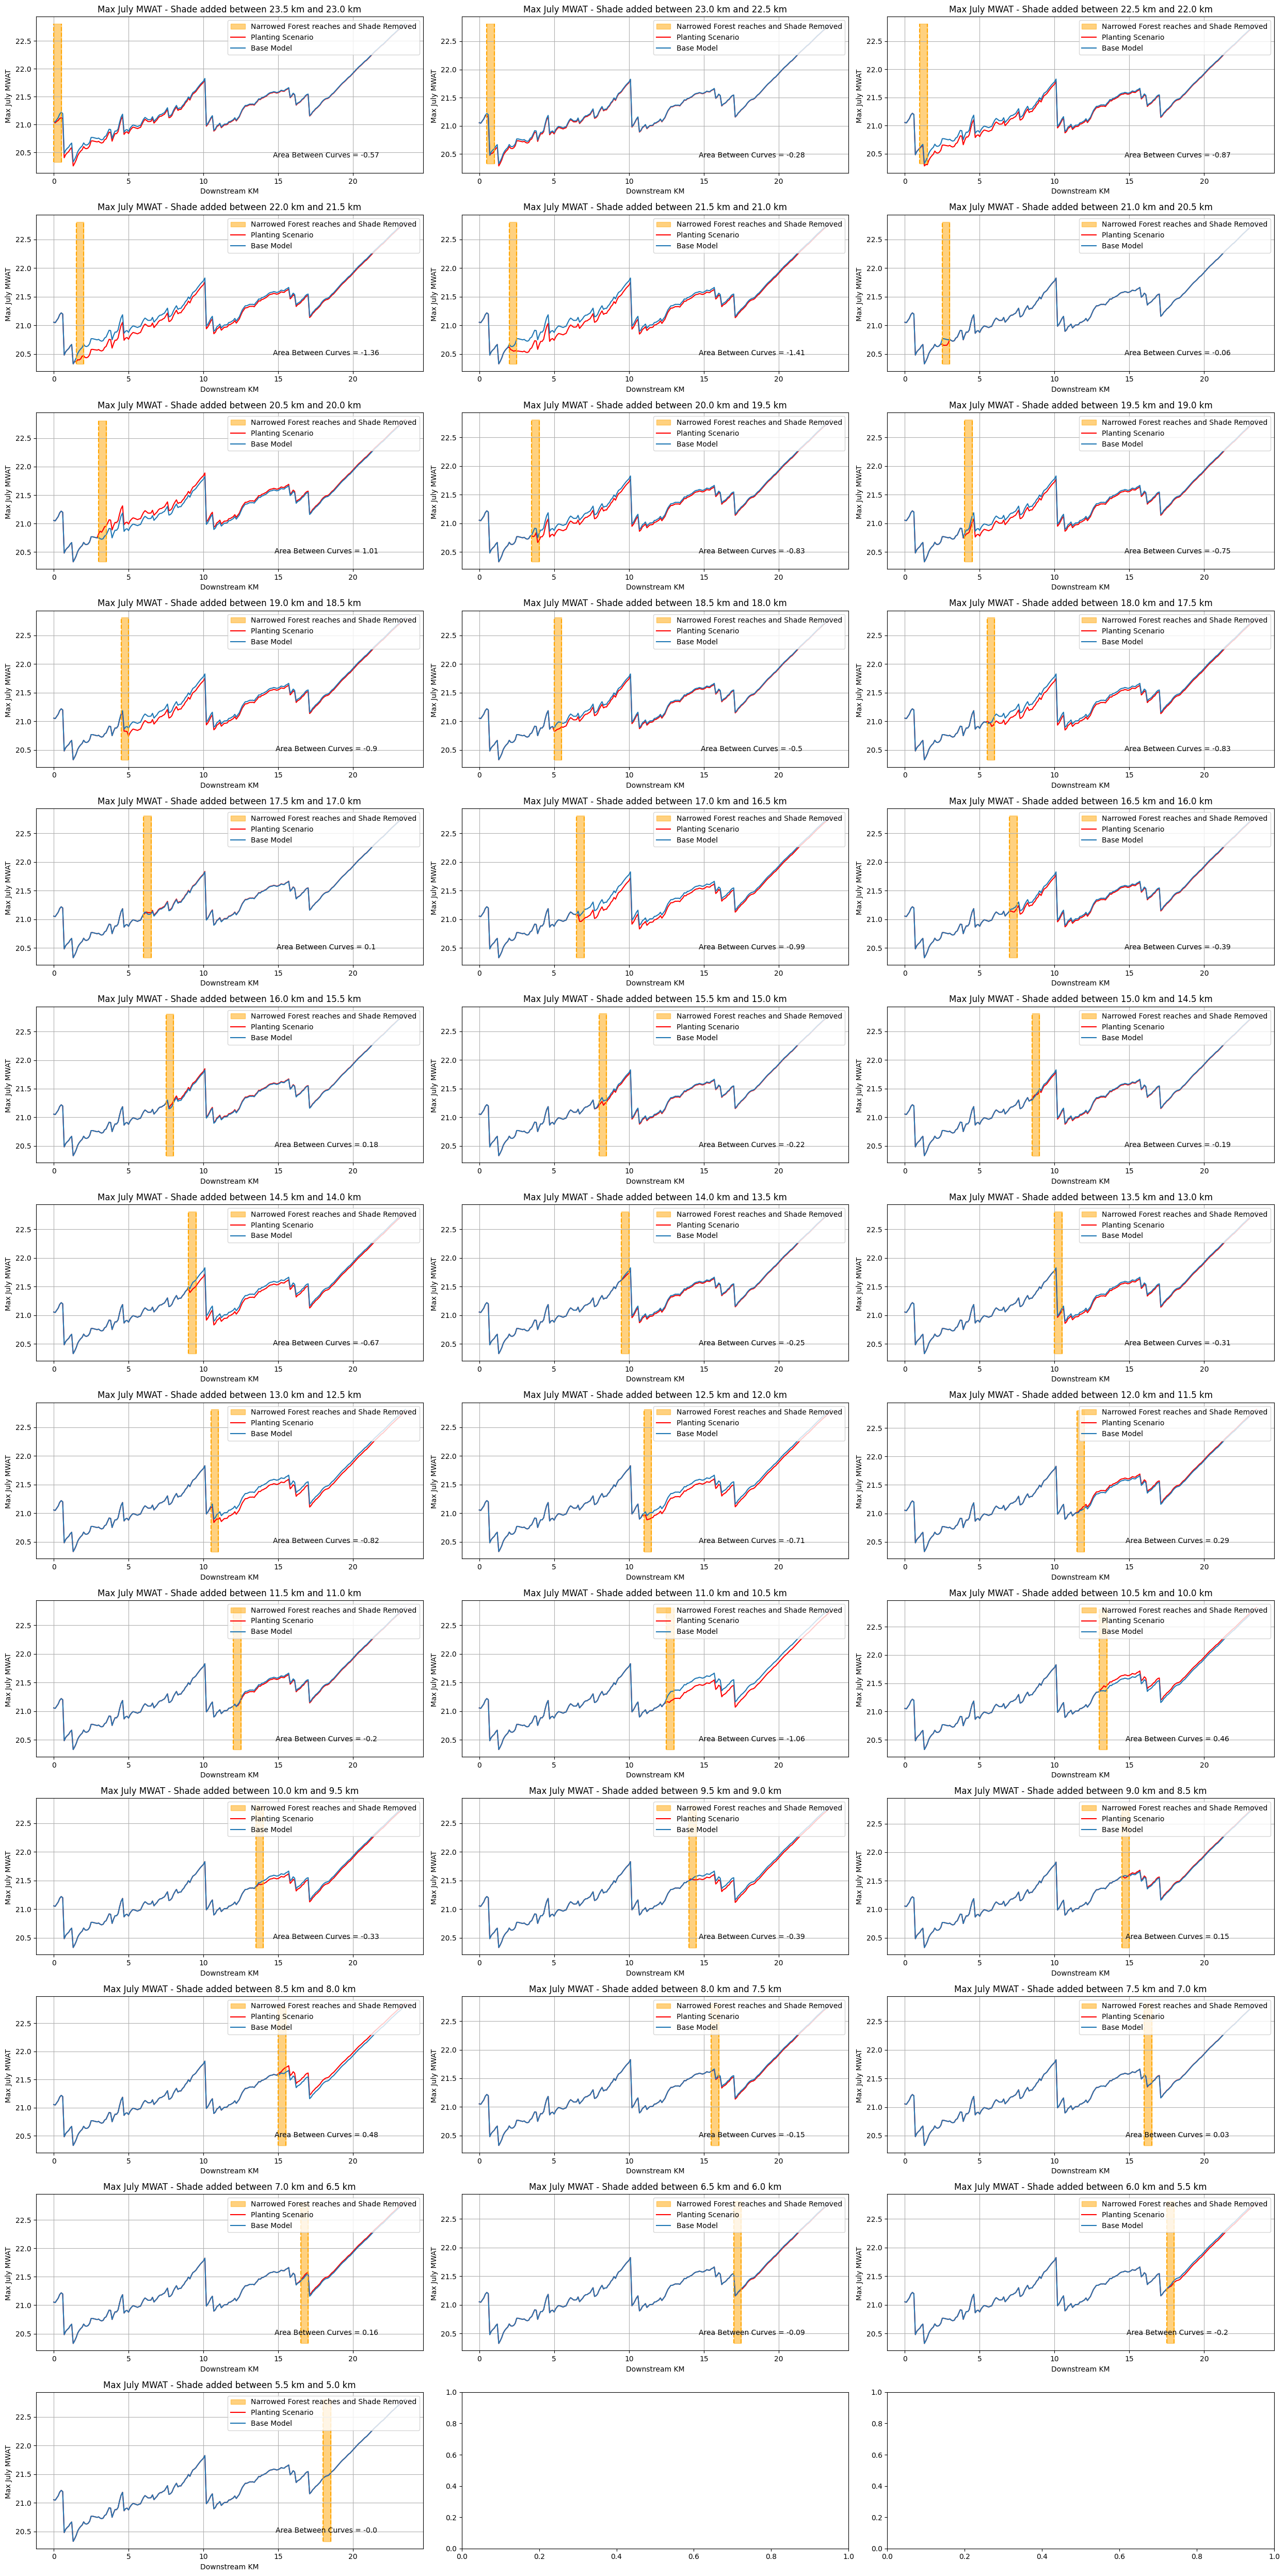

In [59]:
###30% widening Results###
values = [23.5-(x / 2) for x in range(0, 37)]

obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary

upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

obs_rolling_avg = upstreamconstant_modeled_mean.rolling(window=7).max()
obs_max_mwat = obs_rolling_avg.max()
upstreamconstant_modeled['Max MWAT'] = obs_max_mwat.values

#base shade scenario
base_shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
base_hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive
base_shade_df.columns = [float(col) for col in base_shade_df.columns]
base_shade_df.index = daily_index
base_shade = base_shade_df.mean()
base_shade = pd.DataFrame(base_shade)
base_shade = base_shade.reset_index()
base_shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)

#Base width scenario
base_width = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 237))
base_width.columns = [float(col) for col in base_width.columns]
base_width = base_width.iloc[0]#.to_numpy()
base_width = pd.DataFrame(base_width)
base_width = base_width.reset_index()
base_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)

#discts to hold differneces between scenarios
effectiveness_difference = {}
node_shade_base = {}
node_shade_scenario = {}
node_shade_change = {}
node_velocity = {}
node_width_base = {}
node_width_sim = {}
node_width_change = {}
node_depth = {}
node_widthdepth = {}
node_azimuth = {}
node_gradient = {}
count = 0
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios', 'scenario_outputs', 'sensitivity_analysis', 'observed_baseline', 'baseline_treeplanting_widen30_7mtree', f'treeplanting_widen30_7mtree_{km_start}'))
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        # mean july temperature summary
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        sim__rolling_avg = mean_daily_modeled.rolling(window=7).max()
        sim_max_mwat = sim__rolling_avg.max()
        mean_july_modeled['Max MWAT'] = sim_max_mwat.values
        # mwat = mean_daily_modeled.rolling(window=7).max()
        # mwat = mwat.max()
        # mwat = pd.DataFrame(mwat)
        # mean_july_modeled = pd.merge(mean_july_modeled, mwat[0], left_on='NODE_ID', right_index = True, how='left')
        # mean_july_modeled.rename(columns={0: 'Max MWAT'}, inplace=True) 
        
        #saving reach effectiveness
        # difference = mean_july_modeled['Mean July Temp'] - upstreamconstant_modeled['Mean July Temp']
        # norm_difference = difference/km_start
        # norm_difference = norm_difference.values.sum()
        # norm_effectiveness_difference[km_start] = norm_difference
        # effectiveness_difference[km_start] = difference.values.sum()
        
        #doing integration
        x = mean_july_modeled['NODE_ID']
        y1 = mean_july_modeled['Mean July Temp']
        y2 = upstreamconstant_modeled['Mean July Temp']

        
        
        
        
        # Compute absolute difference between the curves
        abs_diff = np.abs(y1 - y2)

        # Use Simpson's rule for numerical integration
        area = simps(abs_diff, x)
        #changing sign of degree kilomters to be negative or positive based on if its cooling (negative) or warming (positive) from restoration
        if (upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp'] <= 0:
            area = area*-1
        area
        
        effectiveness_difference[km_start] = area
        
        #getting effective shade values
        control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
        cc_start = control_file.loc[7]['VALUE']
        cc_start = pd.to_datetime(cc_start)
        cc_end = control_file.loc[8]['VALUE']
        cc_end = pd.to_datetime(cc_end)
        scenario_shade_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
        scenario_shade_df.columns = [float(col) for col in scenario_shade_df.columns]
        scenario_shade_df.index = daily_index
        shade = scenario_shade_df.mean()
        shade = pd.DataFrame(shade)
        shade = shade.reset_index()
        shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)
        reach = shade[(shade['NODE_ID'] <= km_start) & (shade['NODE_ID'] >=km_end)]
        base_reach = base_shade[(base_shade['NODE_ID'] <= km_start) & (base_shade['NODE_ID'] >=km_end)]

        #compare base shade to scenario shade
        node_percent_increase = (base_reach - reach)/base_reach
        node_difference = reach - base_reach
        # Getting Node width differnece as %
        for index, row in node_difference.iterrows():
            node_width_change[row['NODE_ID']] = node_difference.loc[index]['Effective Shade %']
        #reach_mean_percent_increase = reach_percent_increase['Effective Shade %'].mean()    
        
        #reach_shade[km_start] = reach_mean_percent_increase
        reach_shade_base[km_start] = base_reach['Effective Shade %'].mean()
        reach_shade_scenario[km_start] = reach['Effective Shade %'].mean()
        reach_shade_change[km_start] = reach_difference['Effective Shade %'].mean()

         #get reach azimuth
        azimuth = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        azimuth_reach = azimuth[(azimuth['STREAM_KM'] <= km_start) & (azimuth['STREAM_KM'] >=km_end)]
        for index, row in azimuth_reach.iterrows():
            node_azimuth[row['STREAM_KM']] = abs(azimuth_reach.loc[index]['Azm']-180)
        #azimuth_reach_mean = azimuth_reach['Azm'].mean()
        #reach_azimuth[km_start] = abs(azimuth_reach_mean-180)
        
        #get reach gradient 
        gradient = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        gradient_reach = gradient[(gradient['STREAM_KM'] <= km_start) & (gradient['STREAM_KM'] >=km_end)]
        for index, row in gradient_reach.iterrows():
            node_gradient[row['STREAM_KM']] = gradient_reach.loc[index]['GRADIENT']

        #getting mean velocity
        velocity = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Vel.csv'), skiprows=6, usecols=range(1, 237))
        velocity.columns = [float(col) for col in velocity.columns]
        sim_velocity = velocity.mean()#.to_numpy()
        sim_velocity = pd.DataFrame(sim_velocity)
        sim_velocity = sim_velocity.reset_index()
        sim_velocity.rename(columns={'index': 'NODE_ID', 0 : 'Velocity'}, inplace=True)
        velocity_reach = sim_velocity[(sim_velocity['NODE_ID'] <= km_start) & (sim_velocity['NODE_ID'] >=km_end)]
        reach_mean_velocity = velocity_reach['Velocity'].mean()
        reach_velocity[km_start] = reach_mean_velocity
        
        #Getting reach Width
        sim_width = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 237))
        sim_width.columns = [float(col) for col in sim_width.columns]
        sim_width = sim_width.iloc[0]#.to_numpy()
        sim_width = pd.DataFrame(sim_width)
        sim_width = sim_width.reset_index()
        sim_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)
        sim_width = sim_width[(sim_width['NODE_ID'] <= km_start) & (sim_width['NODE_ID'] >=km_end)]
        base_width = base_width[(base_width['NODE_ID'] <= km_start) & (base_width['NODE_ID'] >=km_end)]

        
        # Getting Node widths after simulation
        for index, row in sim_width.iterrows():
            node_width_sim[row['NODE_ID']] = sim_width.loc[index]['Width']
        for index, row in base_width.iterrows():
            node_width_base[row['NODE_ID']] = base_width.loc[index]['Width']
        


        
        #getting depth
        sim_depth = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_DA.csv'), skiprows=6, usecols=range(1, 237))
        sim_depth.columns = [float(col) for col in sim_depth.columns]
        sim_depth = sim_depth.iloc[0]#.to_numpy()
        sim_depth = pd.DataFrame(sim_depth)
        sim_depth = sim_depth.reset_index()
        sim_depth.rename(columns={'index': 'NODE_ID', 0 : f'Depth'}, inplace=True)
        sim_depth = sim_depth[(sim_depth['NODE_ID'] <= km_start) & (sim_depth['NODE_ID'] >=km_end)]
        reach_depth[km_start] = sim_depth['Depth'].mean()
        #width:depth
        reach_widthdepth[km_start] = (sim_width['Width'].mean()/sim_depth['Depth'].mean())
        #plotting
        # Create a new figure with a 3x3 grid of subplots

        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([23.5 - km_start, 23.5 - km_end], upstreamconstant_modeled['Mean July Temp'].min(),upstreamconstant_modeled['Mean July Temp'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(23.5-mean_july_modeled['NODE_ID'], mean_july_modeled['Mean July Temp'], label=f'Planting Scenario', color = 'red')
        axes[count-1].plot(23.5-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Mean July Temp'], label='Base Model')
        #axes[count-1].set_title(f'Max July MWAT - Shade added between {23.5 - km_start} km and {23.5 - km_end} km')
        axes[count-1].set_title(f'Max July MWAT - Shade added between {km_start} km and {km_end} km')

        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Max July MWAT ')  # Replace 'Y Label' with appropriate label
        axes[count-1].text(0.75, 0.1, f'Area Between Curves = {round(area,2)}', horizontalalignment='center', transform=axes[count-1].transAxes)

        # Plot the shade data on the second y-axis
        # axes[count-1] = axes[count-1].twinx()
        # axes[count-1].plot(23.5-shade.index, shade[0], label='Mean Solar Radiation Flux \n At Stream Surface', color='red', alpha = .5)
        # axes[count-1].set_ylabel('Mean Solar Radiation Flux \n At Stream Surface (W/m2)', color = 'red')
        # axes[count-1].tick_params(axis='y', colors='red')

        axes[count-1].vlines([23.5 - km_start, 23.5 - km_end], ymin = upstreamconstant_modeled['Mean July Temp'].min(), ymax = upstreamconstant_modeled['Mean July Temp'].max(),color = 'orange', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'upper right')

        #axes[count-1].legend(loc = 'lower right')
        # axes[count-1].set_xlim([18.3 - km_end-2, 18.3 - km_start+2 ])


    #plt.show()
    #add vertical line where shade is added              
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
#new_folder_name = f"folder_{km_start}"

In [60]:
node_width_base

{23.5: 3.6982,
 23.4: 6.827,
 23.3: 5.3896,
 23.2: 6.6483,
 23.1: 14.6531,
 23.0: 4.3728}

In [61]:
node_width_sim

{23.5: 4.8076,
 23.4: 8.8751,
 23.3: 5.3896,
 23.2: 8.6427,
 23.1: 19.049,
 23.0: 4.3728,
 22.9: 7.0833,
 22.8: 9.0669,
 22.7: 9.0715,
 22.6: 5.0322,
 22.5: 8.788,
 22.4: 5.9299,
 22.3: 3.4896,
 22.2: 6.3137,
 22.1: 8.2882,
 22.0: 7.815,
 21.9: 10.1773,
 21.8: 9.4321,
 21.7: 4.7929,
 21.6: 7.4361,
 21.5: 15.3112,
 21.4: 8.0834,
 21.3: 5.7223,
 21.2: 9.3174,
 21.1: 9.19,
 21.0: 15.3621,
 20.9: 9.6088,
 20.8: 6.7845,
 20.7: 13.9107,
 20.6: 7.819,
 20.5: 15.4499,
 20.4: 15.5739,
 20.3: 20.4713,
 20.2: 15.1593,
 20.1: 17.2533,
 20.0: 12.3799,
 19.9: 11.7162,
 19.8: 13.0358,
 19.7: 8.7749,
 19.6: 12.7414,
 19.5: 13.6405,
 19.4: 9.5499,
 19.3: 10.999,
 19.2: 12.0973,
 19.1: 21.6239,
 19.0: 20.3098,
 18.9: 10.107,
 18.8: 14.0683,
 18.7: 6.6318,
 18.6: 7.0953,
 18.5: 7.2758,
 18.4: 9.6443,
 18.3: 10.7269,
 18.2: 10.1407,
 18.1: 4.9712,
 18.0: 19.6553,
 17.9: 16.2539,
 17.8: 15.2729,
 17.7: 16.4328,
 17.6: 10.2637,
 17.5: 9.5563,
 17.4: 7.8745,
 17.3: 13.1568,
 17.2: 15.072,
 17.1: 10.648,
 17.